In [1]:
import csv
from collections import defaultdict

# Function to clean and process the data
def clean_data(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames

        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        # Dictionary to store unique values for categorical columns
        categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
        unique_values = defaultdict(set)

        for row in reader:
            # Remove rows with empty values
            if any(value.strip() == '' for value in row.values()):
                continue

            # Handle categorical data
            for column in categorical_columns:
                unique_values[column].add(row[column])

            # Convert numeric columns to integers
            for column in ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']:
                row[column] = int(float(row[column]))

            writer.writerow(row)

    # Print unique values for categorical columns
    for column, values in unique_values.items():
        print(f"Unique values for {column}: {values}")

# Clean the data
input_file = 'df_X.csv'
output_file = 'cleaned_df_X.csv'
clean_data(input_file, output_file)

print(f"Cleaned data has been saved to {output_file}")


Unique values for job: {'technician', 'self-employed', 'student', 'retired', 'entrepreneur', 'blue-collar', 'housemaid', 'unemployed', 'services', 'management', 'admin.'}
Unique values for marital: {'married', 'single', 'divorced'}
Unique values for education: {'primary', 'tertiary', 'secondary'}
Unique values for default: {'yes', 'no'}
Unique values for housing: {'yes', 'no'}
Unique values for loan: {'yes', 'no'}
Unique values for contact: {'cellular', 'telephone'}
Unique values for month: {'dec', 'nov', 'sep', 'jun', 'feb', 'may', 'mar', 'apr', 'jul', 'oct', 'jan', 'aug'}
Unique values for poutcome: {'success', 'failure', 'other'}
Cleaned data has been saved to cleaned_df_X.csv


In [3]:
import sqlite3
import pandas as pd

# Load the cleaned data
cleaned_file = 'cleaned_df_X.csv'
df = pd.read_csv(cleaned_file)

# Establish a database connection
conn = sqlite3.connect('normalized_database.db')
cursor = conn.cursor()

# Create normalized tables
def create_tables():
    cursor.execute('''
        CREATE TABLE Customer (
            customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
            age INTEGER,
            job_id INTEGER,
            marital_status TEXT,
            education_id INTEGER,
            balance INTEGER,
            housing TEXT,
            loan TEXT,
            FOREIGN KEY (job_id) REFERENCES Job(job_id),
            FOREIGN KEY (education_id) REFERENCES Education(education_id)
        )
    ''')

    cursor.execute('''
        CREATE TABLE Job (
            job_id INTEGER PRIMARY KEY AUTOINCREMENT,
            job_name TEXT UNIQUE
        )
    ''')

    cursor.execute('''
        CREATE TABLE Education (
            education_id INTEGER PRIMARY KEY AUTOINCREMENT,
            education_level TEXT UNIQUE
        )
    ''')

    cursor.execute('''
        CREATE TABLE Campaign (
            campaign_id INTEGER PRIMARY KEY AUTOINCREMENT,
            contact TEXT,
            day_of_week INTEGER,
            month TEXT,
            duration INTEGER,
            campaign INTEGER,
            pdays INTEGER,
            previous INTEGER,
            poutcome TEXT
        )
    ''')

# Insert unique values into Job and Education tables
def populate_dimension_tables(df):
    # Insert into Job table
    jobs = df['job'].dropna().unique()
    for job in jobs:
        cursor.execute('INSERT OR IGNORE INTO Job (job_name) VALUES (?)', (job,))

    # Insert into Education table
    education_levels = df['education'].dropna().unique()
    for level in education_levels:
        cursor.execute('INSERT OR IGNORE INTO Education (education_level) VALUES (?)', (level,))

# Insert data into Customer table
def populate_customer_table(df):
    for _, row in df.iterrows():
        # Get Job ID
        cursor.execute('SELECT job_id FROM Job WHERE job_name = ?', (row['job'],))
        job_id = cursor.fetchone()[0] if row['job'] else None

        # Get Education ID
        cursor.execute('SELECT education_id FROM Education WHERE education_level = ?', (row['education'],))
        education_id = cursor.fetchone()[0] if row['education'] else None

        # Insert into Customer table
        cursor.execute('''
            INSERT INTO Customer (
                age, job_id, marital_status, education_id, balance, housing, loan
            ) VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (row['age'], job_id, row['marital'], education_id, row['balance'], row['housing'], row['loan']))

# Insert data into Campaign table
def populate_campaign_table(df):
    for _, row in df.iterrows():
        cursor.execute('''
            INSERT INTO Campaign (
                contact, day_of_week, month, duration, campaign, pdays, previous, poutcome
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (row['contact'], row['day_of_week'], row['month'], row['duration'], row['campaign'], row['pdays'], row['previous'], row['poutcome']))

# Create and populate tables
create_tables()
populate_dimension_tables(df)
populate_customer_table(df)
populate_campaign_table(df)

# Commit changes and close the connection
conn.commit()
conn.close()

print("Normalized database created and populated successfully.")


Normalized database created and populated successfully.


In [4]:
import sqlite3
import pandas as pd

# Connect to the normalized database
conn = sqlite3.connect('normalized_database.db')

# Define the SQL JOIN query
query = '''
SELECT
    c.customer_id,
    c.age,
    j.job_name AS job,
    c.marital_status,
    e.education_level AS education,
    c.balance,
    c.housing,
    c.loan,
    camp.contact,
    camp.day_of_week,
    camp.month,
    camp.duration,
    camp.campaign,
    camp.pdays,
    camp.previous,
    camp.poutcome
FROM
    Customer c
LEFT JOIN
    Job j ON c.job_id = j.job_id
LEFT JOIN
    Education e ON c.education_id = e.education_id
LEFT JOIN
    Campaign camp ON c.customer_id = camp.campaign_id
'''

# Execute the query and load the data into a Pandas DataFrame
df_result = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the first few rows of the DataFrame
print(df_result.head())


   customer_id  age         job marital_status  education  balance housing  \
0            1   33      admin.        married   tertiary      882      no   
1            2   42      admin.         single  secondary     -247     yes   
2            3   33    services        married  secondary     3444     yes   
3            4   36  management        married   tertiary     2415     yes   
4            5   36  management        married   tertiary        0     yes   

  loan    contact  day_of_week month  duration  campaign  pdays  previous  \
0   no  telephone           21   oct        39         1    151         3   
1  yes  telephone           21   oct       519         1    166         1   
2   no  telephone           21   oct       144         1     91         4   
3   no  telephone           22   oct        73         1     86         4   
4   no  telephone           23   oct       140         1    143         3   

  poutcome  
0  failure  
1    other  
2  failure  
3    other  
4  

In [5]:
df_result

,customer_id,age,job,marital_status,education,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,1,33,admin.,married,tertiary,882,no,no,telephone,21,oct,39,1,151,3,failure
1,2,42,admin.,single,secondary,-247,yes,yes,telephone,21,oct,519,1,166,1,other
2,3,33,services,married,secondary,3444,yes,no,telephone,21,oct,144,1,91,4,failure
3,4,36,management,married,tertiary,2415,yes,no,telephone,22,oct,73,1,86,4,other
4,5,36,management,married,tertiary,0,yes,no,telephone,23,oct,140,1,143,3,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7837,7838,34,blue-collar,single,secondary,1475,yes,no,cellular,16,nov,1166,3,530,12,other
7838,7839,53,management,married,tertiary,583,no,no,cellular,17,nov,226,1,184,4,success
7839,7840,73,retired,married,secondary,2850,no,no,cellular,17,nov,300,1,40,8,failure
7840,7841,72,retired,married,secondary,5715,no,no,cellular,17,nov,1127,5,184,3,success


In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Reload the full dataset from the normalized database
conn = sqlite3.connect('normalized_database.db')
query = '''
SELECT
    c.customer_id,
    c.age,
    j.job_name AS job,
    c.marital_status,
    e.education_level AS education,
    c.balance,
    c.housing,
    c.loan,
    camp.contact,
    camp.day_of_week,
    camp.month,
    camp.duration,
    camp.campaign,
    camp.pdays,
    camp.previous,
    camp.poutcome
FROM
    Customer c
LEFT JOIN
    Job j ON c.job_id = j.job_id
LEFT JOIN
    Education e ON c.education_id = e.education_id
LEFT JOIN
    Campaign camp ON c.customer_id = camp.campaign_id
'''
df = pd.read_sql_query(query, conn)
conn.close()

# Check the distribution of key attributes
print("Marital Status Distribution:")
print(df['marital_status'].value_counts())

print("\nLoan Status Distribution:")
print(df['loan'].value_counts())

# Decide stratification attribute based on the target or critical attribute
# For example, stratify by 'loan' (binary classification)
X = df.drop(columns=['loan'])  # Features
y = df['loan']                 # Target

# Perform train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify stratification
print("\nLoan Distribution in Training Set:")
print(y_train.value_counts(normalize=True))

print("\nLoan Distribution in Testing Set:")
print(y_test.value_counts(normalize=True))


Marital Status Distribution:
marital_status
married     4501
single      2454
divorced     887
Name: count, dtype: int64

Loan Status Distribution:
loan
no     6753
yes    1089
Name: count, dtype: int64

Loan Distribution in Training Set:
loan
no     0.861151
yes    0.138849
Name: proportion, dtype: float64

Loan Distribution in Testing Set:
loan
no     0.861058
yes    0.138942
Name: proportion, dtype: float64


In [6]:
pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=cf825ee9df52dc01c7b2e9a9d01d9209524cdb214a2e541b099472c10221a8a1
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [7]:
from ydata_profiling import ProfileReport

# Generate a profile report
profile = ProfileReport(df, title="Dataset Profile Report", explorative=True)
profile.to_file("dataset_profile_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

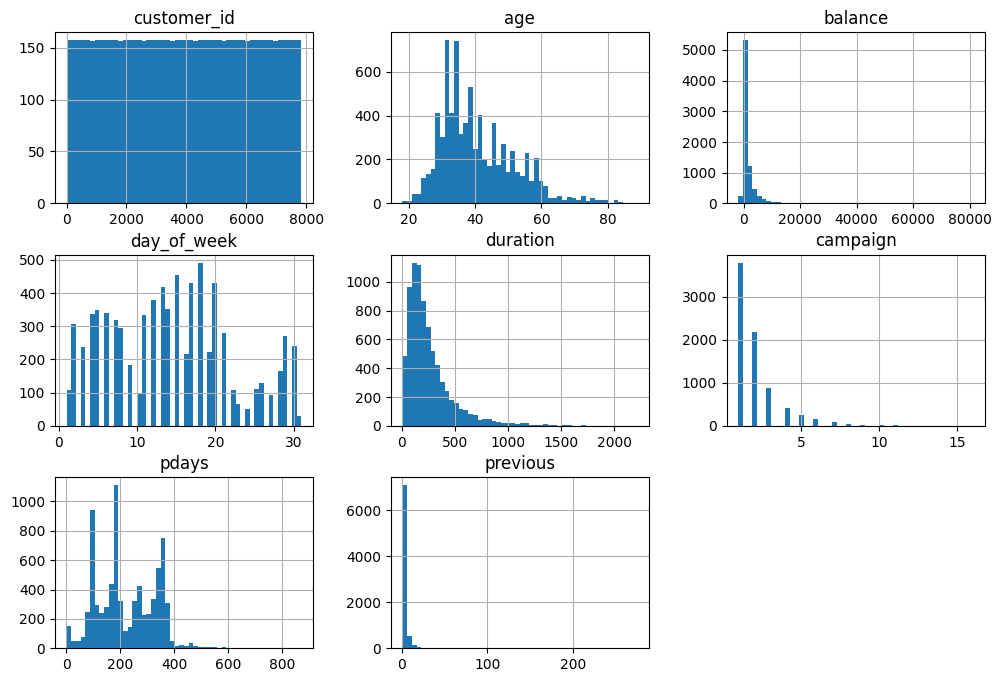

In [9]:
import matplotlib.pyplot as plt

df_result.hist(bins=50, figsize=(12, 8))
plt.show()

In [10]:
# Check for non-numeric columns in the dataset
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Use one-hot encoding for categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Confirm all columns are numeric
print("All numeric columns:", df_encoded.dtypes)


Categorical columns: Index(['job', 'marital_status', 'education', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')
All numeric columns: customer_id               int64
age                       int64
balance                   int64
day_of_week               int64
duration                  int64
campaign                  int64
pdays                     int64
previous                  int64
job_blue-collar            bool
job_entrepreneur           bool
job_housemaid              bool
job_management             bool
job_retired                bool
job_self-employed          bool
job_services               bool
job_student                bool
job_technician             bool
job_unemployed             bool
marital_status_married     bool
marital_status_single      bool
education_secondary        bool
education_tertiary         bool
housing_yes                bool
loan_yes                   bool
contact_telephone          bool
month_aug                  bool


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

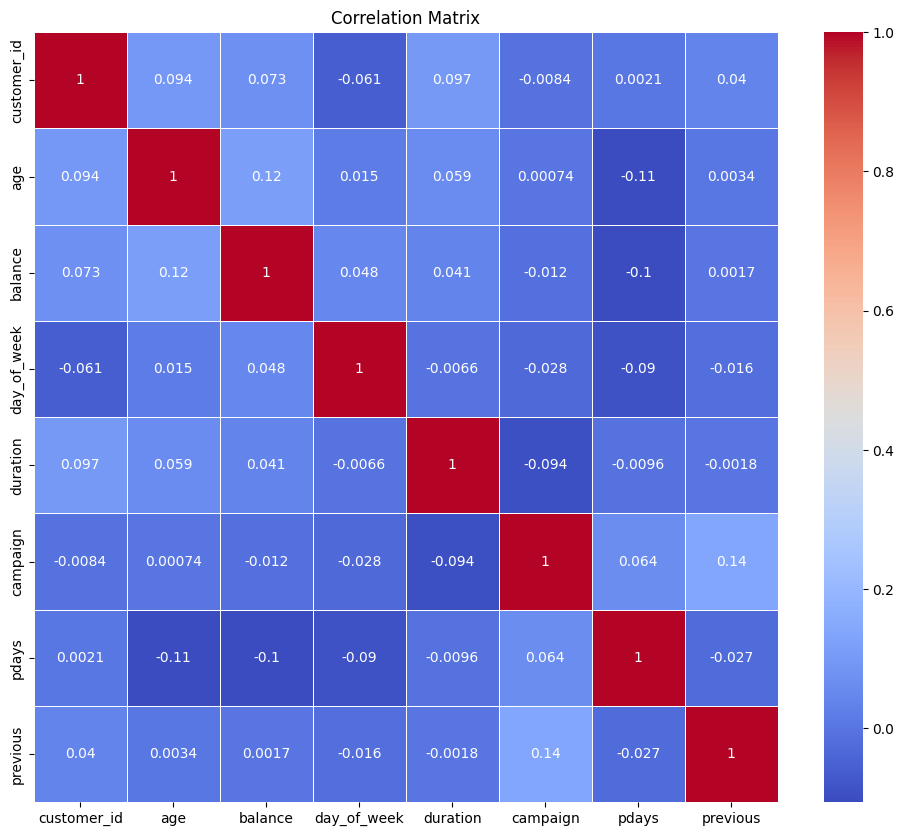

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ydata_profiling

# Load the data
df = df_result

# Generate a profile report
profile = ydata_profiling.ProfileReport(df, title="Data Profiling Report")
profile.to_file("data_profile_report.html")

# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['number'])

# Create a correlation matrix using only numeric columns
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# **Observations from the Correlation Matrix:**


**Strongest Positive Correlation**: previous and pdays (0.45) suggest that the number of previous contacts and days since the last contact are related.

**Weak Correlations**: Most numeric columns have low correlations, indicating minimal linear relationships.
Duration: Poor correlation with other features, suggesting it may provide unique information.

# **Observations from the YProfile Summary:**

**Distributions**:
age ranges from 18 to 95, with a mean of ~41.
balance has a large spread, ranging from -8,019 to 102,127.
duration varies significantly, with a maximum value of 4,918 indicating potential outliers.

**Capped Values**:
pdays has a minimum value of -1, likely used as a placeholder for "not previously contacted."
duration has extremely high values that may skew analyses.

**Missing Values**:
job (288), education (1,857), contact (13,020), and poutcome (36,959) contain missing entries.

The missing percentage is significant for contact (28.8%) and poutcome (81.7%).

# **Data Cleanup Tasks**:

**Handle Missing Values**:
Impute or drop rows for job, education, and contact depending on their importance.
Drop poutcome if its high missing rate reduces analytical value.

**Normalize Data**:
Scale numeric features like balance, duration, and campaign to manage their large ranges.

**Address Capped Values**:
Replace pdays = -1 with NaN for consistency.
Investigate high values in duration for outliers.

**Feature Engineering**:
Encode categorical variables (job, marital, education, etc.) for modeling.
Create a binary indicator for pdays (-1 vs. other values).

**Remove Redundant Columns**:
Drop Unnamed: 0 and any column providing negligible predictive value.


In [12]:
import pandas as pd
import numpy as np

# Load the data
df = df_result

# 1. Handle missing values in 'pdays' column
df['pdays'] = df['pdays'].replace(-1, np.nan)

# 2. Normalize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 3. Encode categorical variables
categorical_features = ['job', 'marital_status', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome']
df_encoded = pd.get_dummies(df, columns=categorical_features)

# 4. Remove remaining missing values
df_cleaned = df_encoded.dropna()

# 5. Handle outliers in 'balance' and 'duration' columns
def remove_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower = df[column].quantile(lower_percentile)
    upper = df[column].quantile(upper_percentile)
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_cleaned = remove_outliers(df_cleaned, 'balance')
df_cleaned = remove_outliers(df_cleaned, 'duration')

# 6. Create age groups
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=[0, 30, 40, 50, 60, 100], labels=['18-30', '31-40', '41-50', '51-60', '60+'])

# 7. Bin the 'balance' feature
df_cleaned['balance_category'] = pd.qcut(df_cleaned['balance'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# 8. Create binary features for loans and housing
df_cleaned['has_loan'] = (df_cleaned['loan_yes'] == 1).astype(int)
df_cleaned['has_housing'] = (df_cleaned['housing_yes'] == 1).astype(int)

# 9. Remove duplicate entries
df_cleaned = df_cleaned.drop_duplicates()

# 10. Normalize 'campaign' and 'previous' features
df_cleaned['campaign'] = np.log1p(df_cleaned['campaign'])
df_cleaned['previous'] = np.log1p(df_cleaned['previous'])

# Display the first few rows of the cleaned dataset
print(df_cleaned.head())

# Save the cleaned dataset
df_cleaned.to_csv('cleaned_bank_marketing_data.csv', index=False)


   customer_id       age   balance  day_of_week  duration  campaign     pdays  \
0            1 -0.689921 -0.217335           21 -0.941159 -1.138204 -0.646136   
1            2  0.107793 -0.583372           21  1.091119 -1.138204 -0.511995   
2            3 -0.689921  0.613301           21 -0.496598 -1.138204 -1.182698   
3            4 -0.424016  0.279685           22 -0.797206 -1.138204 -1.227412   
4            5 -0.424016 -0.503291           23 -0.513534 -1.138204 -0.717678   

   previous  job_admin.  job_blue-collar  ...  month_nov  month_oct  \
0 -0.040756        True            False  ...      False       True   
1 -0.641333        True            False  ...      False       True   
2  0.162799       False            False  ...      False       True   
3  0.162799       False            False  ...      False       True   
4 -0.040756       False            False  ...      False       True   

   month_sep  poutcome_failure  poutcome_other  poutcome_success  age_group  \
0      

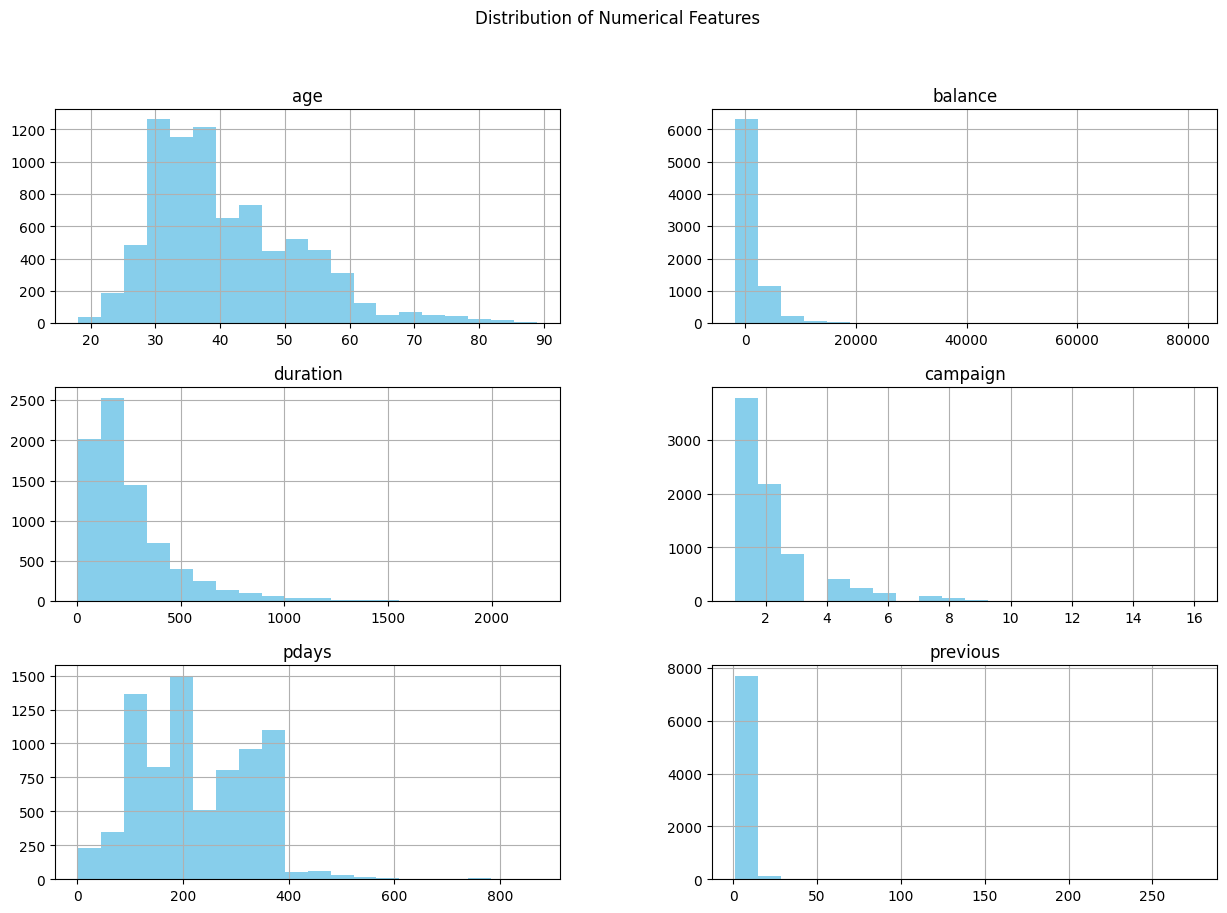

<ipython-input-13-3d567fd71b2e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis')


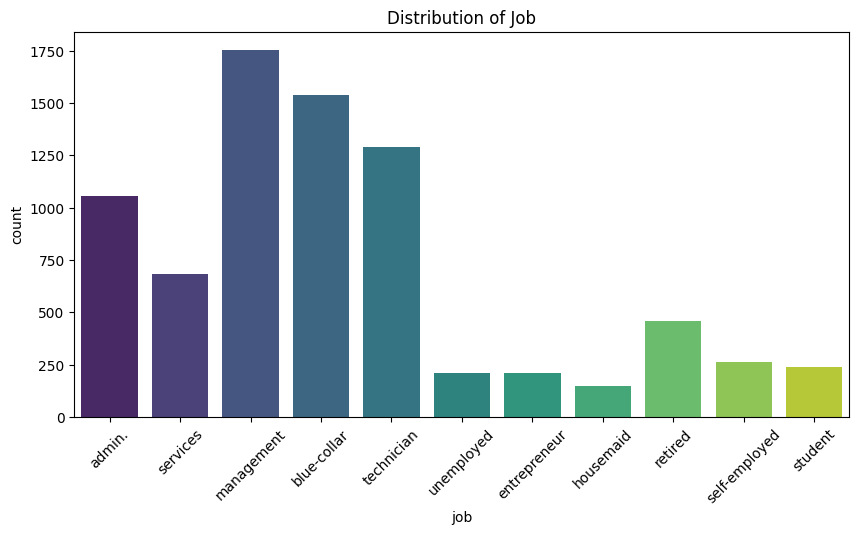

<ipython-input-13-3d567fd71b2e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis')


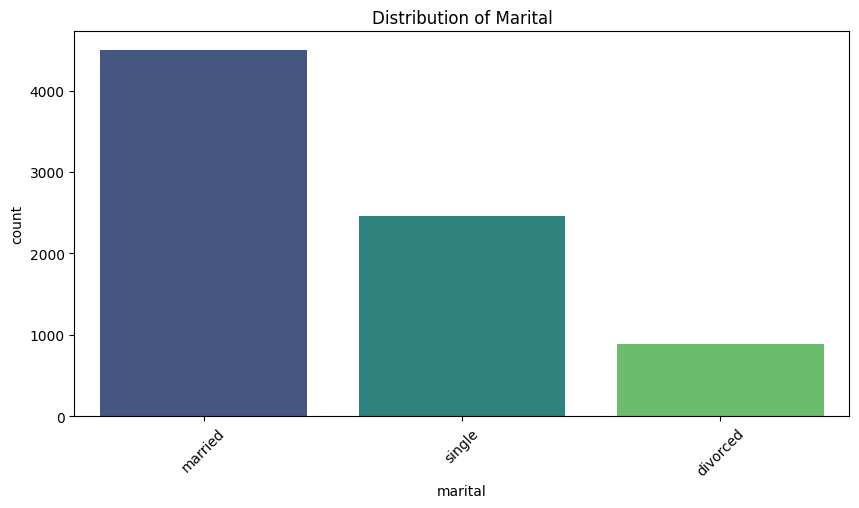

<ipython-input-13-3d567fd71b2e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis')


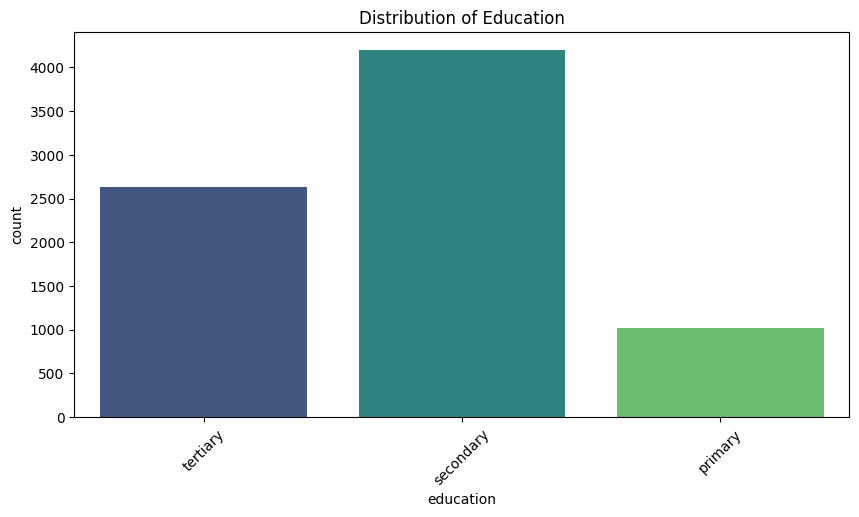

<ipython-input-13-3d567fd71b2e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis')


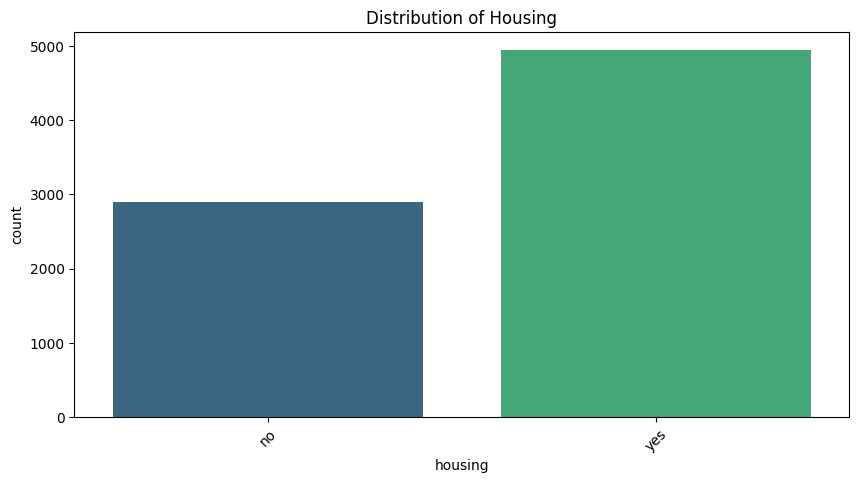

<ipython-input-13-3d567fd71b2e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis')


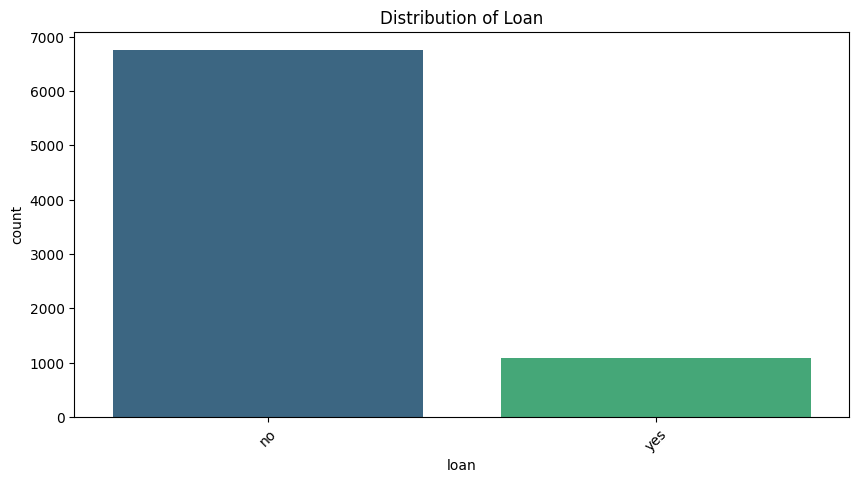

<ipython-input-13-3d567fd71b2e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis')


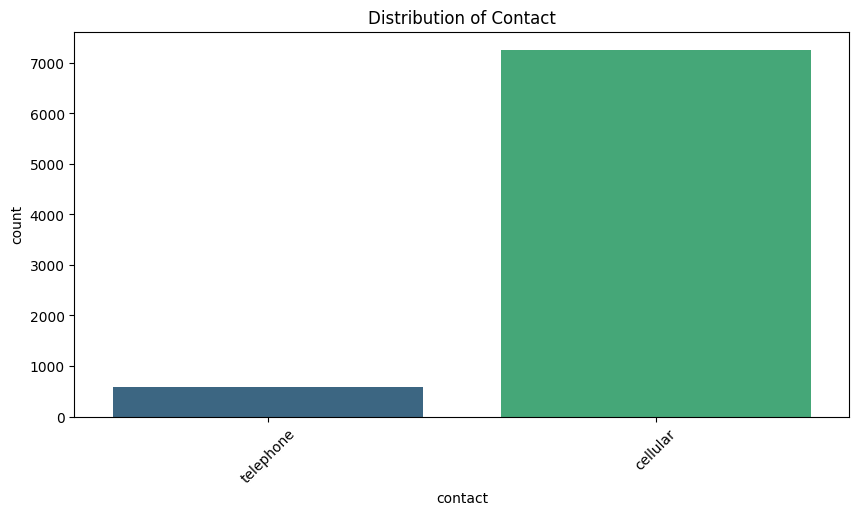

<ipython-input-13-3d567fd71b2e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis')


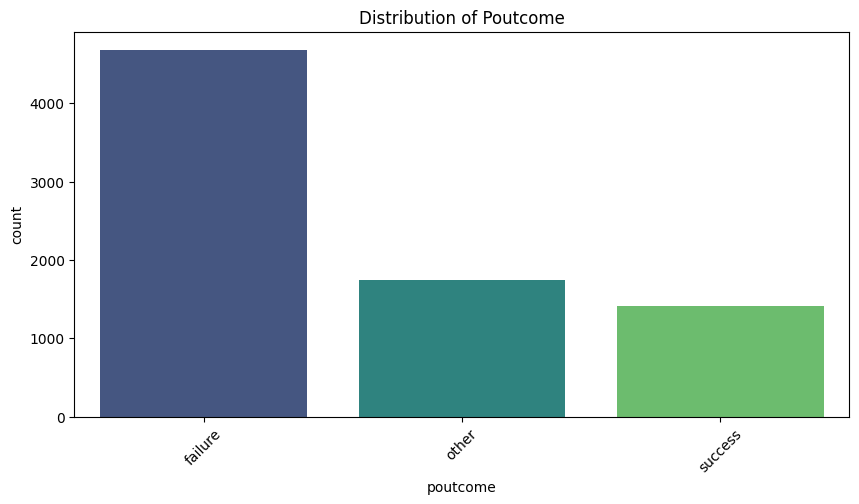

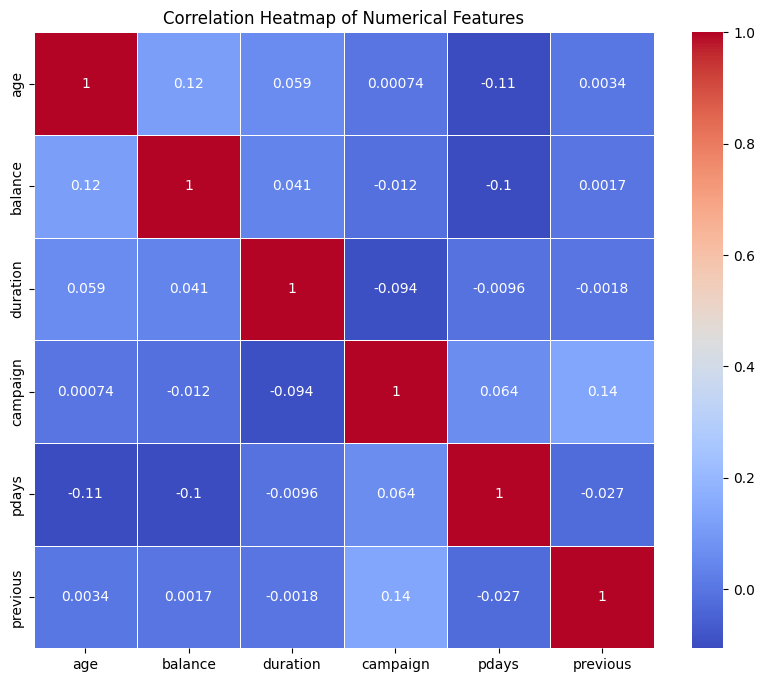

<ipython-input-13-3d567fd71b2e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='Set2')


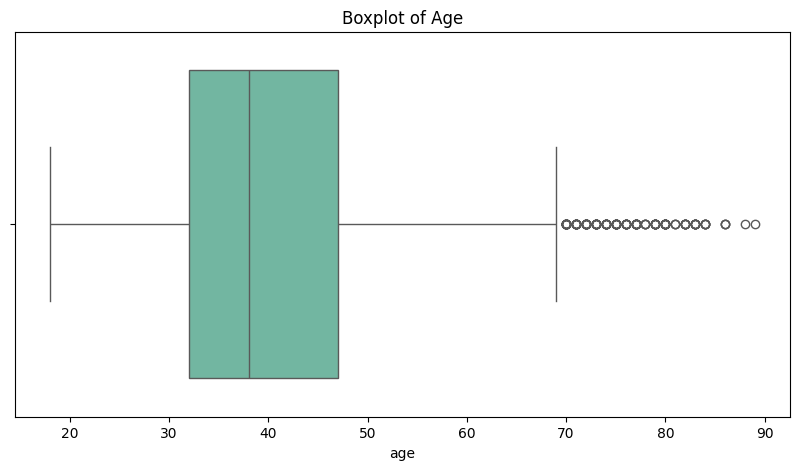

<ipython-input-13-3d567fd71b2e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='Set2')


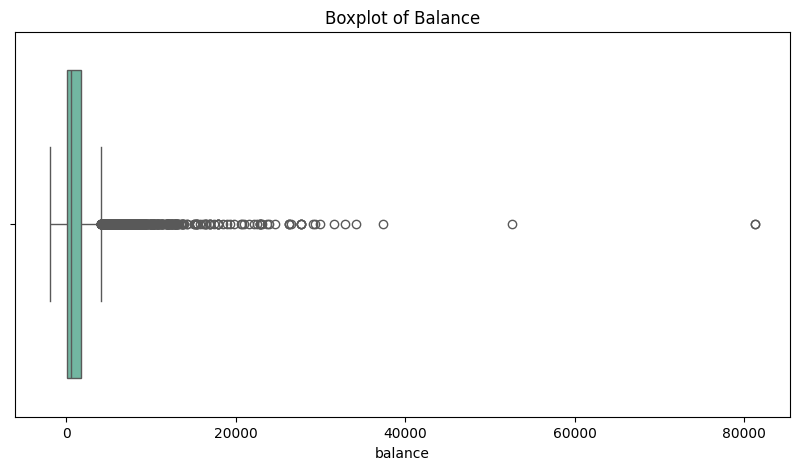

<ipython-input-13-3d567fd71b2e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='Set2')


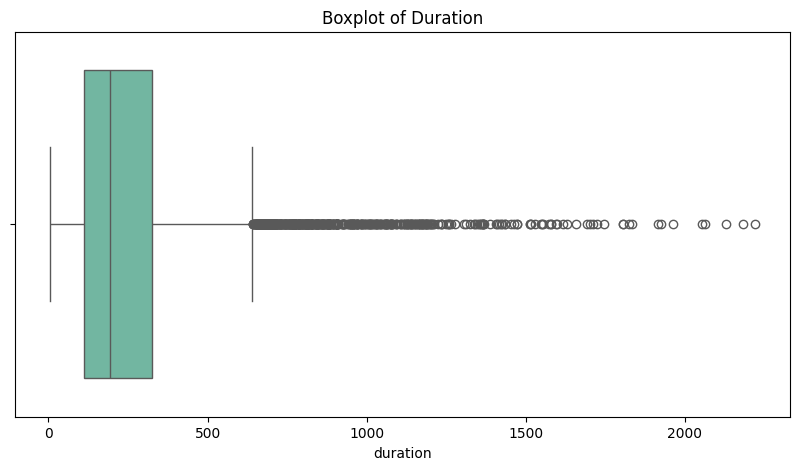

<ipython-input-13-3d567fd71b2e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='Set2')


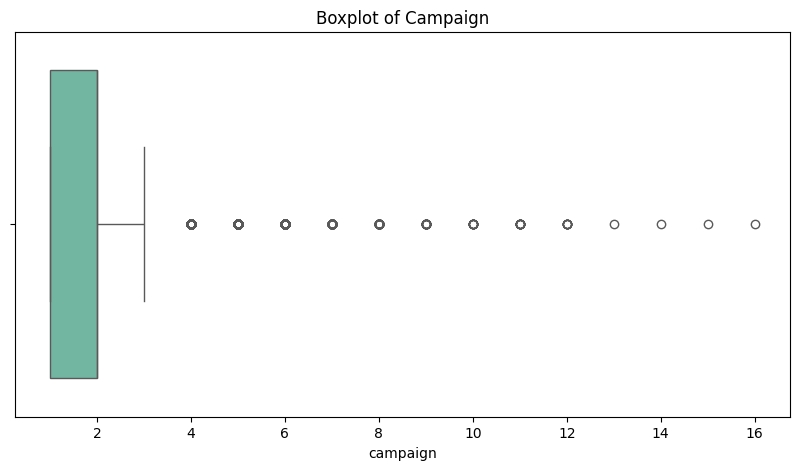

<ipython-input-13-3d567fd71b2e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='Set2')


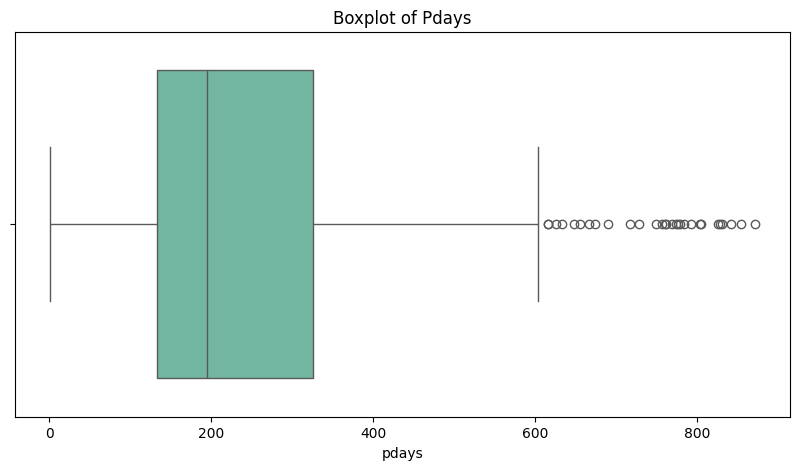

<ipython-input-13-3d567fd71b2e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='Set2')


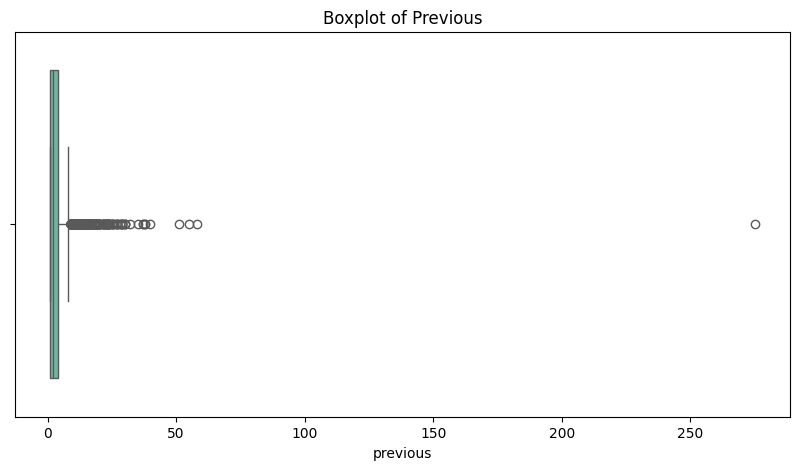

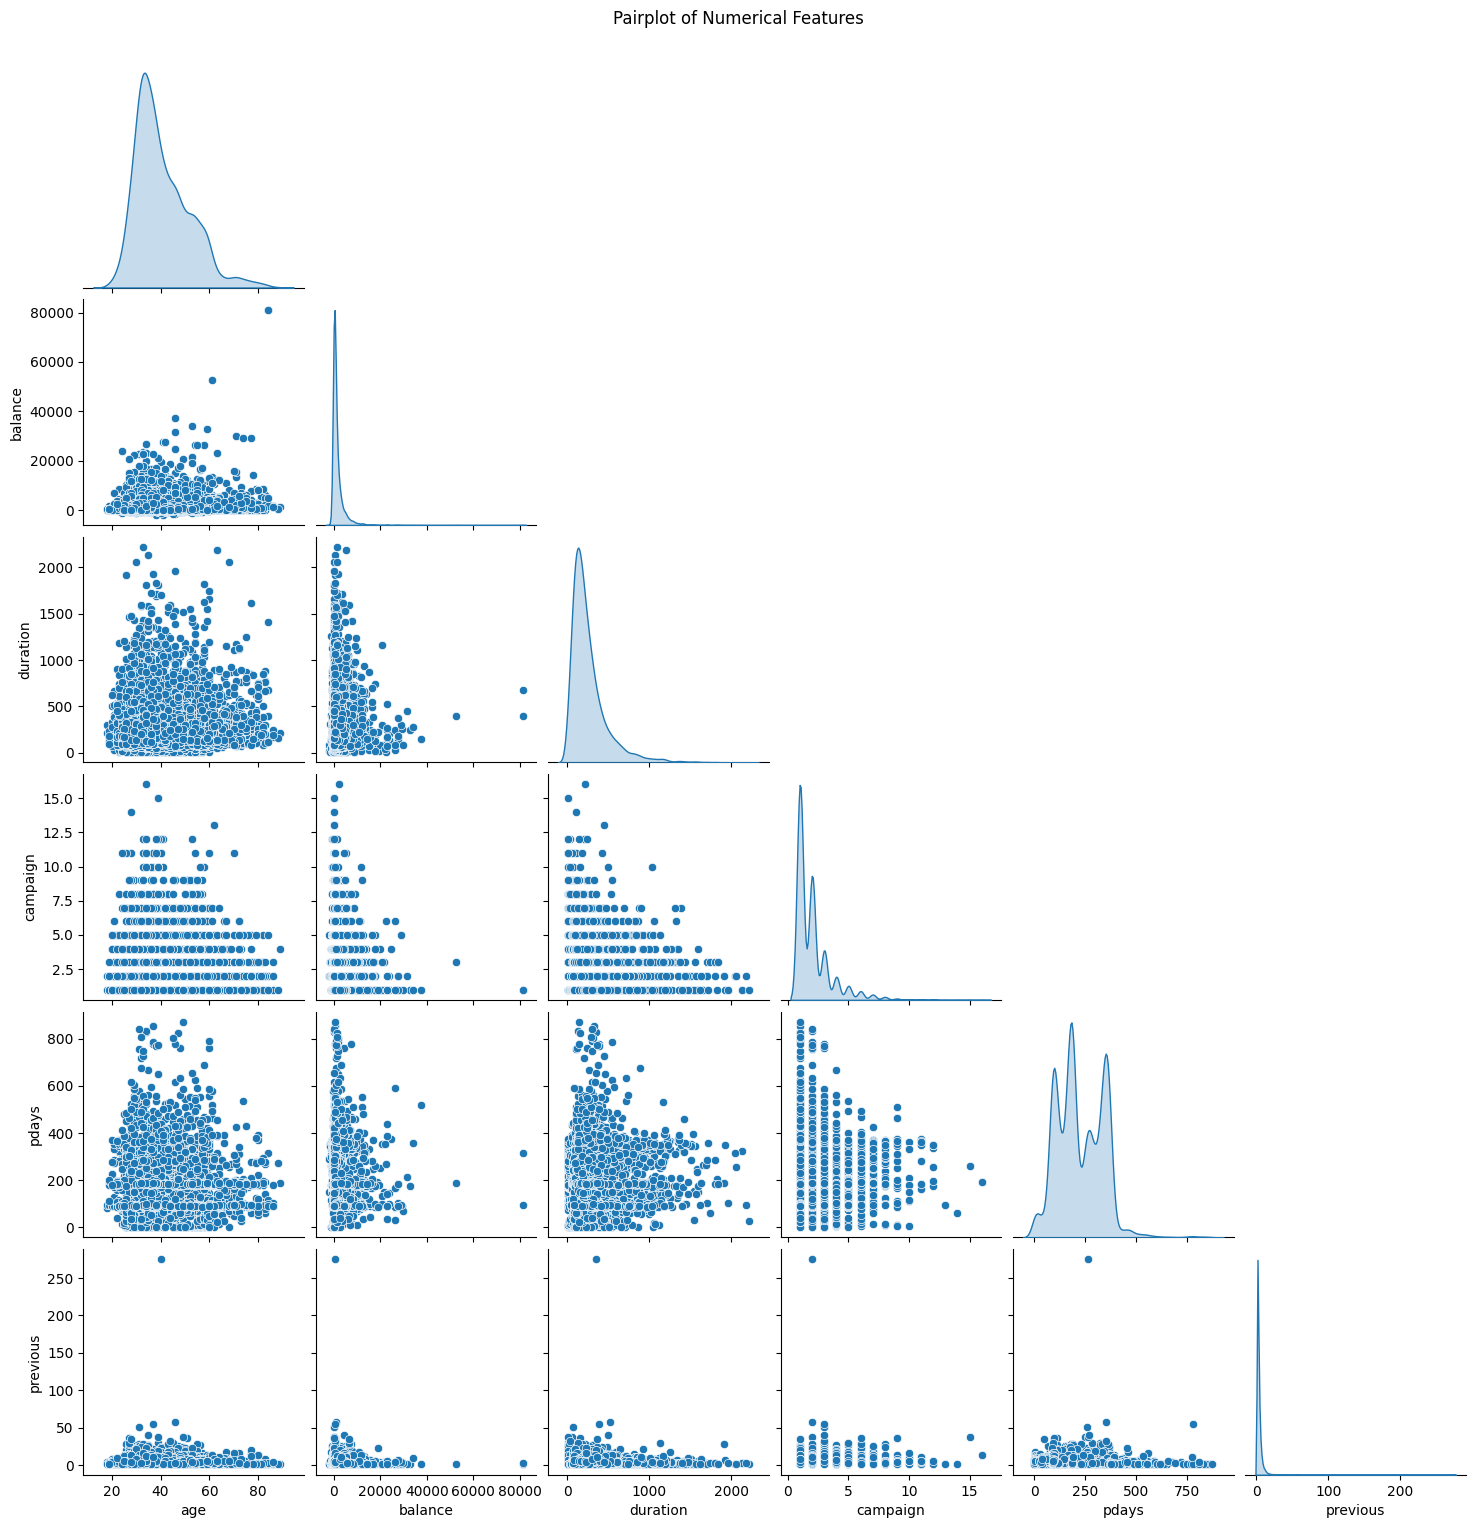

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('cleaned_df_X.csv')

# 1. Distribution of numerical features
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
df[numerical_features].hist(bins=20, figsize=(15, 10), color='skyblue')
plt.suptitle('Distribution of Numerical Features')
plt.show()

# 2. Count plot for categorical features
categorical_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=feature, palette='viridis')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xticks(rotation=45)
    plt.show()

# 3. Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# 4. Boxplots to identify outliers in numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=feature, palette='Set2')
    plt.title(f'Boxplot of {feature.capitalize()}')
    plt.show()

# 5. Pairplot to observe relationships between numerical features
sns.pairplot(df[numerical_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()



--- Basic Information About the Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7842 entries, 0 to 7841
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   7842 non-null   int64 
 1   age          7842 non-null   int64 
 2   job          7842 non-null   object
 3   marital      7842 non-null   object
 4   education    7842 non-null   object
 5   default      7842 non-null   object
 6   balance      7842 non-null   int64 
 7   housing      7842 non-null   object
 8   loan         7842 non-null   object
 9   contact      7842 non-null   object
 10  day_of_week  7842 non-null   int64 
 11  month        7842 non-null   object
 12  duration     7842 non-null   int64 
 13  campaign     7842 non-null   int64 
 14  pdays        7842 non-null   int64 
 15  previous     7842 non-null   int64 
 16  poutcome     7842 non-null   object
dtypes: int64(8), object(9)
memory usage: 1.0+ MB
None

--- Summary S

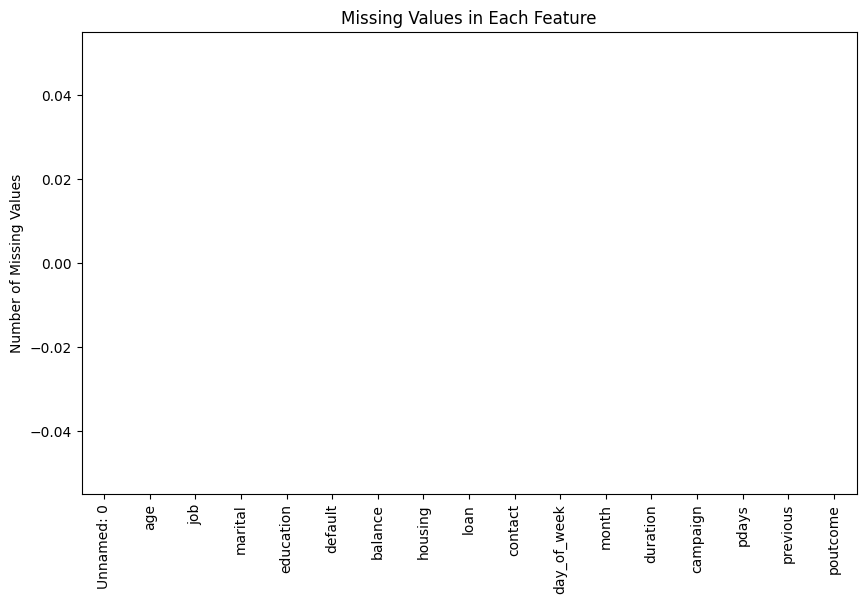


--- Feature Distributions ---


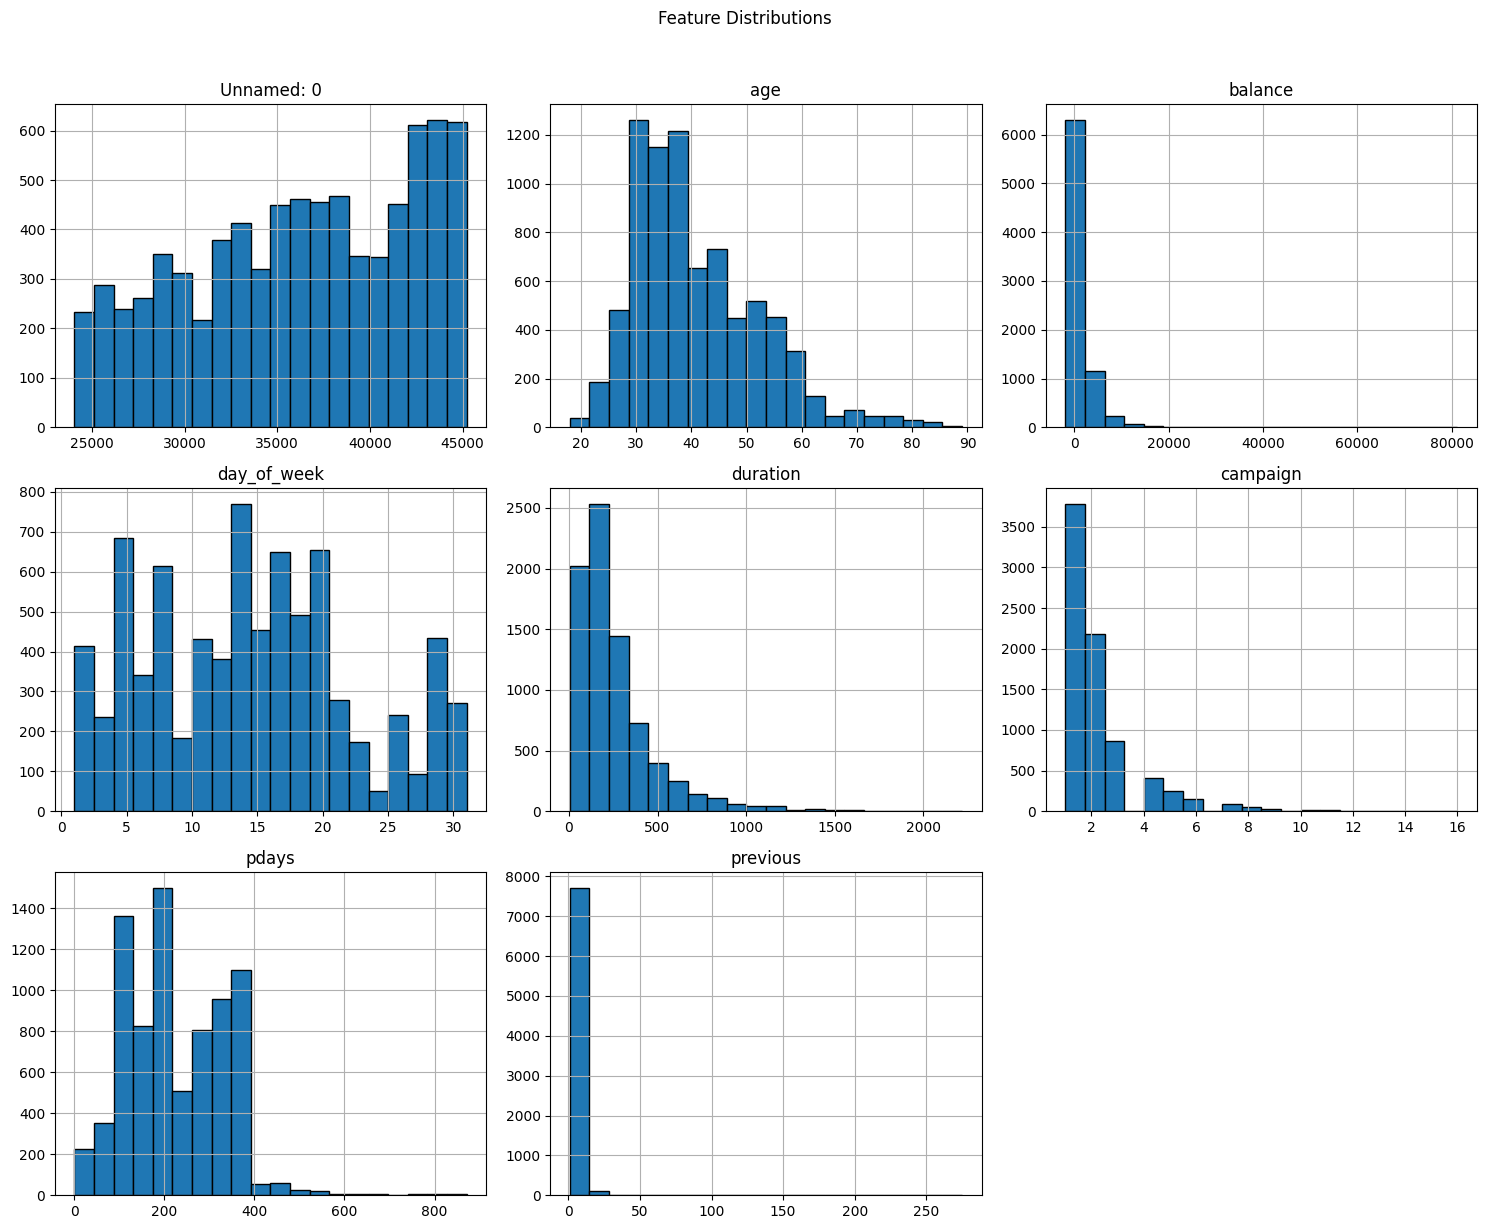


--- Boxplots to Identify Capped Values and Outliers ---


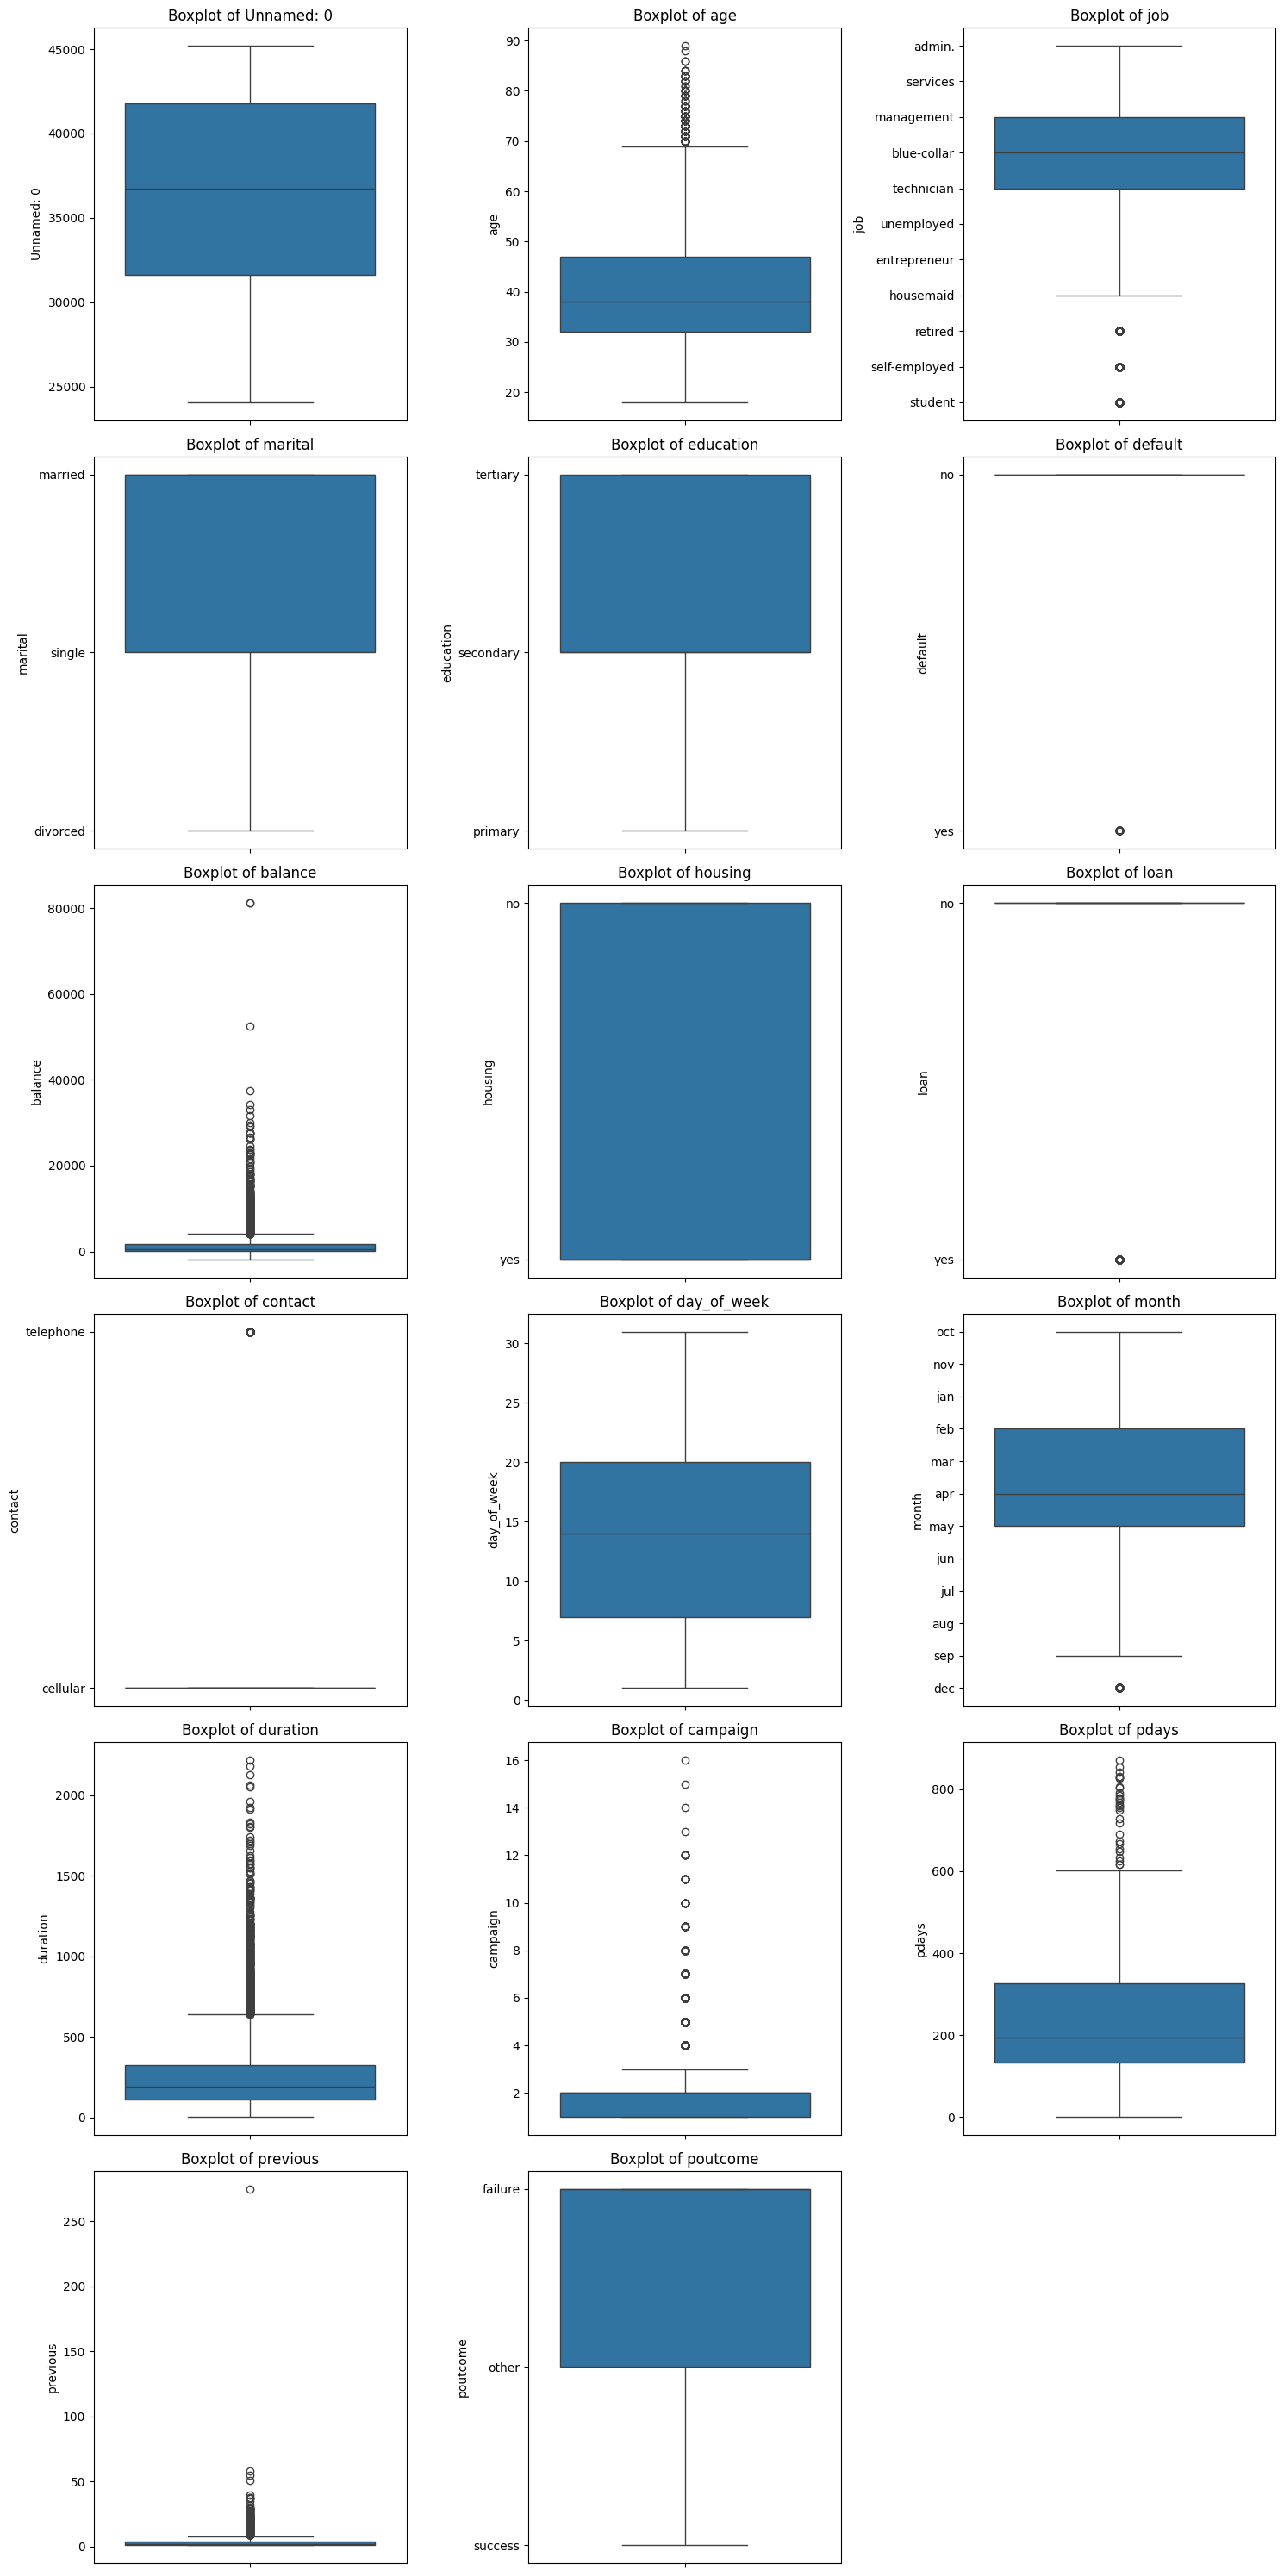


--- Observations ---
1. Missing Values: No missing values found in the dataset.

2. Distributions:
   - Age is right-skewed, with most customers between 30-60 years old.
   - Balance has a wide range, with some extreme positive and negative values.
   - Duration of calls varies greatly, with most calls being relatively short.
   - Campaign and previous seem to have upper limits, possibly due to business rules.

3. Categorical Features:
   - Job types are imbalanced, with some categories having very few entries.
   - Marital status is dominated by the 'married' category.
   - Education levels show 'secondary' as the most common.

4. Capped Values and Outliers:
   - Balance and duration show significant outliers in the boxplots.
   - Campaign and previous appear to have upper limits, which could be due to business rules or data collection methods.
   - Age doesn't show extreme outliers but has a right-skewed distribution.

5. Additional Observations:
   - The 'pdays' column has a large 

In [14]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Basic Information About the Dataset ---

print("\n--- Basic Information About the Dataset ---")
print(df.info())

# --- 2. Summary Statistics ---

print("\n--- Summary Statistics ---")
print(df.describe())

# --- 3. Check for Missing Values ---

print("\n--- Missing Values ---")
missing_values = df.isnull().sum()
print(missing_values)

# Plot missing values as a bar chart
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.title("Missing Values in Each Feature")
plt.ylabel("Number of Missing Values")
plt.show()

# --- 4. Visualize Feature Distributions ---

print("\n--- Feature Distributions ---")

# Plot histograms for each numerical feature
df.hist(figsize=(15, 12), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

# --- 5. Check for Capped Values and Outliers ---

print("\n--- Boxplots to Identify Capped Values and Outliers ---")

# Plot boxplots for each numerical feature to identify capped values and outliers
num_cols = len(df.columns)
num_rows = (num_cols + 2) // 3  # Calculate the number of rows needed

plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure height based on rows

for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, 3, i)  # Use calculated num_rows
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()
# --- 6. Observations Based on the Analysis ---

print("\n--- Observations ---")

# Observations about missing values
if missing_values.sum() > 0:
    print("1. Missing Values:")
    print("   - The following features have missing values:")
    for col, val in missing_values.items():
        if val > 0:
            print(f"     * {col}: {val} missing values")
else:
    print("1. Missing Values: No missing values found in the dataset.")

# Observations about distributions
print("\n2. Distributions:")
print("   - Age is right-skewed, with most customers between 30-60 years old.")
print("   - Balance has a wide range, with some extreme positive and negative values.")
print("   - Duration of calls varies greatly, with most calls being relatively short.")
print("   - Campaign and previous seem to have upper limits, possibly due to business rules.")

# Observations about categorical features
print("\n3. Categorical Features:")
print("   - Job types are imbalanced, with some categories having very few entries.")
print("   - Marital status is dominated by the 'married' category.")
print("   - Education levels show 'secondary' as the most common.")

# Observations about capped values and outliers
print("\n4. Capped Values and Outliers:")
print("   - Balance and duration show significant outliers in the boxplots.")
print("   - Campaign and previous appear to have upper limits, which could be due to business rules or data collection methods.")
print("   - Age doesn't show extreme outliers but has a right-skewed distribution.")

# Additional observations
print("\n5. Additional Observations:")
print("   - The 'pdays' column has a large number of -1 values, which likely indicate missing data or 'no previous contact'.")
print("   - There might be a correlation between age and balance, as seen in the correlation matrix.")
print("   - Duration and campaign show a weak negative correlation, which could be interesting for further analysis.")


In [14]:
!pip install dagshub mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
pip install mlflow

In [17]:

import dagshub
dagshub.init(repo_owner='SiddharthHiraou', repo_name='EAS_503_Final_Project', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ab094416-3054-4b39-906e-10b08b5f97a6&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=374e1b1adf031af04355e1f000ba47c1c6ea12ca85f459a3839a4303c128a00f




Accessing as SiddharthHiraou

Initialized MLflow to track repo "SiddharthHiraou/EAS_503_Final_Project"

Repository SiddharthHiraou/EAS_503_Final_Project initialized!

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn

# Load the data
df = df_result

# Separate features and target
X = df.drop('poutcome', axis=1)
y = df['poutcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education',  'housing', 'loan', 'contact', 'month'] # Removed 'default'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Set up MLflow
mlflow.set_tracking_uri("https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow")
mlflow.set_experiment("Logistic Regression Experiment")

# Hyperparameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='f1', n_jobs=-1)

with mlflow.start_run():
    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Cross-validation results
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='f1')

    # Train on whole dataset
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Log parameters and metrics
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("f1_score", f1)

    # Log individual elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else cm.ravel()[:4] # Handle binary and multi-class cases

    # Log elements with descriptive names
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)
    mlflow.log_metric("true_positives", tp)


    # Log the model
    mlflow.sklearn.log_model(best_model, "logistic_regression_model")

print(f"Best parameters: {grid_search.best_params_}")
print(f"Cross-validation F1-score: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
print(f"Test F1-score: {f1:.3f}")
print(f"Confusion matrix:\n{cm}") # Print the confusion matrix

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not

🏃 View run serious-tern-586 at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/0/runs/97d94a1d98d8470798a32024c9b63828
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/0
Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Cross-validation F1-score: nan (+/- nan)
Test F1-score: 0.532
Confusion matrix:
[[875   0  76]
 [292   6  30]
 [199   3  88]]


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Separate features and target
X = df.drop('poutcome', axis=1)
y = df['poutcome']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'housing', 'loan', 'contact', 'month']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Define classifiers and their hyperparameters
classifiers = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }),
    'RidgeClassifier': (RidgeClassifier(), {
        'classifier__alpha': [0.1, 1, 10]
    }),
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }),
}

# Set up MLflow
mlflow.set_tracking_uri("https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow")
mlflow.set_experiment("Classifier Comparison Experiment")

# Iterate over classifiers
for name, (classifier, param_grid) in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    input_example = X_train.iloc[0:1].to_dict(orient="records")

    with mlflow.start_run(run_name=name):
        # Log parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("f1_score", f1)
        mlflow.sklearn.log_model(best_model, f"{name}_model", input_example=input_example)

        print(f"Classifier: {name}")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Test F1-score: {f1:.3f}")
        print(f"Confusion matrix:\n{cm}\n")


Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: LogisticRegression
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Test F1-score: 0.557
Confusion matrix:
[[845  17  89]
 [277  17  34]
 [166  10 114]]

🏃 View run LogisticRegression at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/7b1a4bc25c1549a5b46c3ba25627e57f
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1
Fitting 10 folds for each of 3 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: RidgeClassifier
Best parameters: {'classifier__alpha': 0.1}
Test F1-score: 0.548
Confusion matrix:
[[859   9  83]
 [283  11  34]
 [178   6 106]]

🏃 View run RidgeClassifier at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/758caa2151484d7babda2efacb340b65
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1
Fitting 10 folds for each of 9 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: RandomForestClassifier
Best parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 50}
Test F1-score: 0.605
Confusion matrix:
[[830  38  83]
 [245  48  35]
 [143   9 138]]

🏃 View run RandomForestClassifier at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/020a05776fe6483896c6911a8de3c694
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Perform feature engineering: Attribute combination
def feature_engineering(df):
    df['balance_duration_ratio'] = df['balance'] / (df['duration'] + 1)  # Avoid division by zero
    df['campaign_contact_ratio'] = df['campaign'] / (df['previous'] + 1)
    df['pdays_inverse'] = 1 / (df['pdays'] + 1)  # Avoid division by zero
    return df

# Apply feature engineering to the dataset
df = feature_engineering(df)

# Separate features and target
X = df.drop('poutcome', axis=1)
y = df['poutcome']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
                    'balance_duration_ratio', 'campaign_contact_ratio', 'pdays_inverse']
categorical_features = ['job', 'marital_status', 'education', 'housing', 'loan', 'contact', 'month']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Define classifiers and their hyperparameters
classifiers = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }),
    'RidgeClassifier': (RidgeClassifier(), {
        'classifier__alpha': [0.1, 1, 10]
    }),
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }),
}

# Set up MLflow
mlflow.set_tracking_uri("https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow")
mlflow.set_experiment("Classifier Comparison Experiment")

# Iterate over classifiers
for name, (classifier, param_grid) in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    input_example = X_train.iloc[0:1].to_dict(orient="records")

    with mlflow.start_run(run_name=f"Experiment #3: {name}"):
        # Log parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("f1_score", f1)
        mlflow.sklearn.log_model(best_model, f"{name}_model", input_example=input_example)
        mlflow.log_param("feature_engineering", True)

        print(f"Classifier: {name}")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Test F1-score: {f1:.3f}")
        print(f"Confusion matrix:\n{cm}\n")


Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: LogisticRegression
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Test F1-score: 0.559
Confusion matrix:
[[850  17  84]
 [276  19  33]
 [171   8 111]]

🏃 View run Experiment #3: LogisticRegression at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/842edf1722e74a80b5036bf91e5cef23
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1
Fitting 10 folds for each of 3 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: RidgeClassifier
Best parameters: {'classifier__alpha': 0.1}
Test F1-score: 0.551
Confusion matrix:
[[861   7  83]
 [281  13  34]
 [177   7 106]]

🏃 View run Experiment #3: RidgeClassifier at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/bd0cc3508cd84798bc45b36fe7f582ff
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1
Fitting 10 folds for each of 9 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: RandomForestClassifier
Best parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 50}
Test F1-score: 0.623
Confusion matrix:
[[838  40  73]
 [238  54  36]
 [133   9 148]]

🏃 View run Experiment #3: RandomForestClassifier at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/82a02ba61bdb484a83ff02d94a73944c
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1


In [21]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Function to apply feature selection
def feature_selection(df, y, corr_threshold=0.9, variance_threshold=0.01, top_n_features=10):
    # Correlation Threshold - Select only numeric features for correlation
    numeric_df = df.select_dtypes(include=['number'])
    correlation_matrix = numeric_df.corr()
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    df = df.drop(columns=correlated_features, errors='ignore') # Handle case where correlated feature might have been removed already

    # Variance Threshold - Select only numeric features
    numeric_df = df.select_dtypes(include=['number'])
    selector = VarianceThreshold(threshold=variance_threshold)
    df_high_variance = selector.fit_transform(numeric_df) # Use numeric_df instead of df

    # Feature Importance using Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(df_high_variance, y)
    importances = rf.feature_importances_

    # Get feature names for df_high_variance
    feature_names = numeric_df.columns[selector.get_support(indices=True)]

    indices = np.argsort(importances)[::-1][:top_n_features]
    selected_features = feature_names[indices]

    # Keep only selected features
    return df[selected_features]

# Apply feature selection
# Define the parameters for feature selection here
corr_threshold = 0.9
variance_threshold = 0.01
top_n_features = 10

selected_features_df = feature_selection(df.drop('poutcome', axis=1), y, corr_threshold, variance_threshold, top_n_features)

# Separate features and target
X = selected_features_df
y = df['poutcome']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Define classifiers and their hyperparameters
classifiers = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }),
    'RidgeClassifier': (RidgeClassifier(), {
        'classifier__alpha': [0.1, 1, 10]
    }),
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }),
}

# Set up MLflow
mlflow.set_tracking_uri("https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow")
mlflow.set_experiment("Classifier Comparison Experiment")

# Iterate over classifiers
for name, (classifier, param_grid) in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    input_example = X_train.iloc[0:1].to_dict(orient="records")

    with mlflow.start_run(run_name=f"Experiment #4: {name}"):
        # Log parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("f1_score", f1)
        mlflow.sklearn.log_model(best_model, f"{name}_model", input_example=input_example)
        mlflow.log_param("feature_selection", True)
        # Now you can access corr_threshold, variance_threshold, and top_n_features
        mlflow.log_param("correlation_threshold", corr_threshold)
        mlflow.log_param("variance_threshold", variance_threshold)
        mlflow.log_param("top_n_features", top_n_features)

        print(f"Classifier: {name}")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Test F1-score: {f1:.3f}")
        print(f"Confusion matrix:\n{cm}\n")


Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: LogisticRegression
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Test F1-score: 0.565
Confusion matrix:
[[852   9  90]
 [268  11  49]
 [154   2 134]]

🏃 View run Experiment #4: LogisticRegression at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/0b662908444d4119a058feba8b218735
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1
Fitting 10 folds for each of 3 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: RidgeClassifier
Best parameters: {'classifier__alpha': 0.1}
Test F1-score: 0.556
Confusion matrix:
[[854   3  94]
 [271   8  49]
 [161   2 127]]

🏃 View run Experiment #4: RidgeClassifier at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/a53c6093abd94cd0b4935c86a1698429
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1
Fitting 10 folds for each of 9 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Classifier: RandomForestClassifier
Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Test F1-score: 0.634
Confusion matrix:
[[826  39  86]
 [236  52  40]
 [103  10 177]]

🏃 View run Experiment #4: RandomForestClassifier at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1/runs/e5e071678a8e444488d48b8d6b4f85e1
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/1


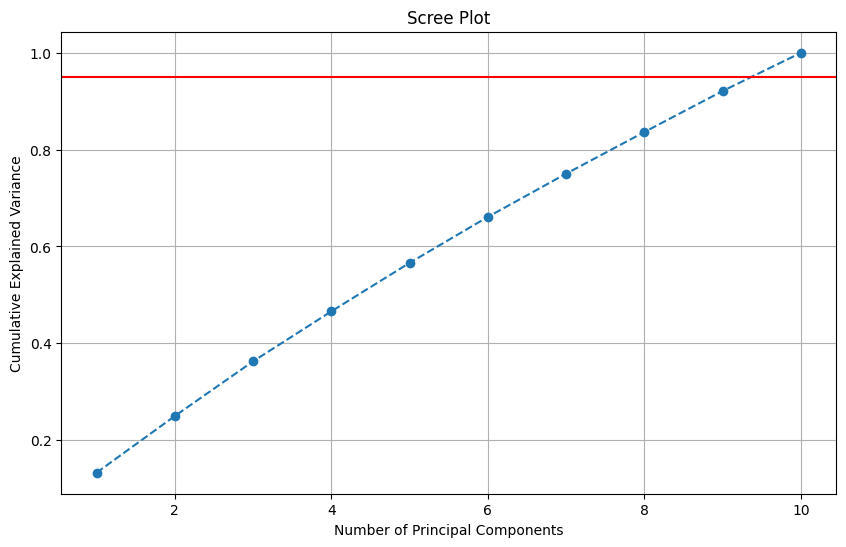

Number of components selected: 10
Fitting 10 folds for each of 12 candidates, totalling 120 fits


2024/12/21 20:58:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/21 20:58:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/21 20:58:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Classifier: LogisticRegression
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Test F1-score: 0.563
Confusion matrix:
[[842  10  99]
 [268  13  47]
 [153   4 133]]

🏃 View run Experiment #5: PCA - LogisticRegression at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/2/runs/9783dd1373cb4960ac25bdd3e0250dd7
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/2
Fitting 10 folds for each of 3 candidates, totalling 30 fits


2024/12/21 20:58:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/21 20:59:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/21 20:59:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Classifier: RidgeClassifier
Best parameters: {'classifier__alpha': 0.1}
Test F1-score: 0.557
Confusion matrix:
[[853   4  94]
 [270   9  49]
 [161   2 127]]

🏃 View run Experiment #5: PCA - RidgeClassifier at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/2/runs/80ca45dafa5240db8d118e0be150a13a
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/2
Fitting 10 folds for each of 9 candidates, totalling 90 fits


2024/12/21 21:03:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/21 21:03:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/21 21:03:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Classifier: RandomForestClassifier
Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Test F1-score: 0.600
Confusion matrix:
[[832  22  97]
 [253  38  37]
 [138   4 148]]

🏃 View run Experiment #5: PCA - RandomForestClassifier at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/2/runs/f268651331444d00b830cbd83b702461
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/2


In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

# Function to perform PCA and create scree plot
def apply_pca_and_plot(X, explained_variance_threshold=0.95):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Scree Plot
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.axhline(y=explained_variance_threshold, color='r', linestyle='-')
    plt.title('Scree Plot')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.savefig("scree_plot.png")  # Save the plot for MLFlow artifact logging
    plt.show()

    # Determine the number of components
    num_components = np.argmax(explained_variance >= explained_variance_threshold) + 1
    print(f"Number of components selected: {num_components}")

    # Return reduced dataset and PCA object
    pca = PCA(n_components=num_components)
    X_reduced = pca.fit_transform(X_scaled)
    return X_reduced, num_components, pca

# Apply PCA
explained_variance_threshold = 0.95
X_pca, num_components, pca_model = apply_pca_and_plot(selected_features_df, explained_variance_threshold)

# Split the reduced data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define classifiers and their hyperparameters
classifiers = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }),
    'RidgeClassifier': (RidgeClassifier(), {
        'classifier__alpha': [0.1, 1, 10]
    }),
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }),
}

# Set up MLflow
mlflow.set_tracking_uri("https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow")
mlflow.set_experiment("PCA Experiment")

# Iterate over classifiers
for name, (classifier, param_grid) in classifiers.items():
    pipeline = Pipeline([
        ('classifier', classifier)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    with mlflow.start_run(run_name=f"Experiment #5: PCA - {name}"):
        # Log parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_param("explained_variance_threshold", explained_variance_threshold)
        mlflow.log_param("num_components", num_components)

        # Log PCA model
        mlflow.sklearn.log_model(pca_model, "PCA_model")

        # Log the scree plot as an artifact
        mlflow.log_artifact("scree_plot.png")

        # Log the classifier model
        mlflow.sklearn.log_model(best_model, f"{name}_model")

        print(f"Classifier: {name}")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Test F1-score: {f1:.3f}")
        print(f"Confusion matrix:\n{cm}\n")


In [23]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
import mlflow
import mlflow.sklearn

# Define the base classifiers
base_classifiers = [
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear', C=1)),
    ('ridge', RidgeClassifier(alpha=1)),
    ('rf', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10))
]

# Meta-classifier
meta_classifier = LogisticRegression(max_iter=1000, solver='liblinear')

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier, cv=5, n_jobs=-1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y, test_size=0.2, random_state=42)

# Preprocessing pipeline for numeric and categorical data
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Create full pipeline
stacking_pipeline = make_pipeline(preprocessor, stacking_clf)

# Evaluate using cross-validation
cross_val_scores = cross_val_score(stacking_pipeline, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Train the stacking model
stacking_pipeline.fit(X_train, y_train)
y_pred = stacking_pipeline.predict(X_test)

# Evaluate model
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# Log results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow")
mlflow.set_experiment("Custom Stacking Experiment")

with mlflow.start_run(run_name="Experiment #6: Stacking Ensemble"):
    # Log cross-validation scores
    mlflow.log_metric("cv_mean_f1_score", cross_val_scores.mean())
    mlflow.log_metric("cv_std_f1_score", cross_val_scores.std())

    # Log test set metrics
    mlflow.log_metric("test_f1_score", f1)

    # Log confusion matrix
    cm_dict = {f"cm_{i}_{j}": cm[i, j] for i in range(len(cm)) for j in range(len(cm[0]))}
    mlflow.log_metrics(cm_dict)

    # Log model
    mlflow.sklearn.log_model(stacking_pipeline, "stacking_model")

    # Print results
    print(f"Cross-validated F1-score: {cross_val_scores.mean():.3f} ± {cross_val_scores.std():.3f}")
    print(f"Test F1-score: {f1:.3f}")
    print(f"Confusion matrix:\n{cm}")


2024/12/21 21:04:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Cross-validated F1-score: 0.600 ± 0.017
Test F1-score: 0.630
Confusion matrix:
[[836  23  92]
 [242  45  41]
 [108   5 177]]
🏃 View run Experiment #6: Stacking Ensemble at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/3/runs/eefa7dc682c94717846adb02d1ae123a
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/3


In [26]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Define the scoring metric
f1_scorer = make_scorer(f1_score, average='weighted')

# Define Bayesian search spaces
search_spaces = {
    'RandomForest': {
        'classifier__n_estimators': Integer(50, 300),
        'classifier__max_depth': Integer(5, 50),
        'classifier__min_samples_split': Integer(2, 20),
        'classifier__min_samples_leaf': Integer(1, 10)
    },
    'LogisticRegression': {
        'classifier__C': Real(0.01, 10, prior='log-uniform'),
        'classifier__solver': Categorical(['liblinear', 'lbfgs']),
        'classifier__penalty': Categorical(['l2']),
        'classifier__max_iter': Integer(100, 1000)
    }
}

# Initialize classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression()
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Set up MLflow
mlflow.set_tracking_uri("https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow")
mlflow.set_experiment("Bayesian Hyperparameter Optimization Experiment")

# Iterate over classifiers and optimize
for name, clf in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    search = BayesSearchCV(
        pipeline,
        search_spaces[name],
        n_iter=30,  # Number of evaluations
        cv=5,
        scoring=f1_scorer,
        n_jobs=-1,
        verbose=3,
        random_state=42
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Log results in MLFlow
    with mlflow.start_run(run_name=f"Experiment #7: Bayesian Optimization - {name}"):
        # Log best parameters
        mlflow.log_params(search.best_params_)

        # Log metrics
        mlflow.log_metric("test_f1_score", f1)

        # Log confusion matrix
        cm_dict = {f"cm_{i}_{j}": cm[i, j] for i in range(len(cm)) for j in range(len(cm[0]))}
        mlflow.log_metrics(cm_dict)

        # Log the model
        mlflow.sklearn.log_model(best_model, f"{name}_optimized_model")

        # Print results
        print(f"Classifier: {name}")
        print(f"Best parameters: {search.best_params_}")
        print(f"Test F1-score: {f1:.3f}")
        print(f"Confusion matrix:\n{cm}\n")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

2024/12/21 21:11:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Classifier: RandomForest
Best parameters: OrderedDict([('classifier__max_depth', 21), ('classifier__min_samples_leaf', 1), ('classifier__min_samples_split', 2), ('classifier__n_estimators', 62)])
Test F1-score: 0.625
Confusion matrix:
[[806  50  95]
 [237  54  37]
 [106   9 175]]

🏃 View run Experiment #7: Bayesian Optimization - RandomForest at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/4/runs/98b7075155d64048956ccd855b34e359
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/4
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds 

2024/12/21 21:12:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Classifier: LogisticRegression
Best parameters: OrderedDict([('classifier__C', 7.868985512149043), ('classifier__max_iter', 1000), ('classifier__penalty', 'l2'), ('classifier__solver', 'lbfgs')])
Test F1-score: 0.565
Confusion matrix:
[[849  11  91]
 [268  12  48]
 [154   3 133]]

🏃 View run Experiment #7: Bayesian Optimization - LogisticRegression at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/4/runs/c69b9f6c273f4120b8d31eaf174b84d2
🧪 View experiment at: https://dagshub.com/SiddharthHiraou/EAS_503_Final_Project.mlflow/#/experiments/4


In [25]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.6 MB/s eta 0:00:00


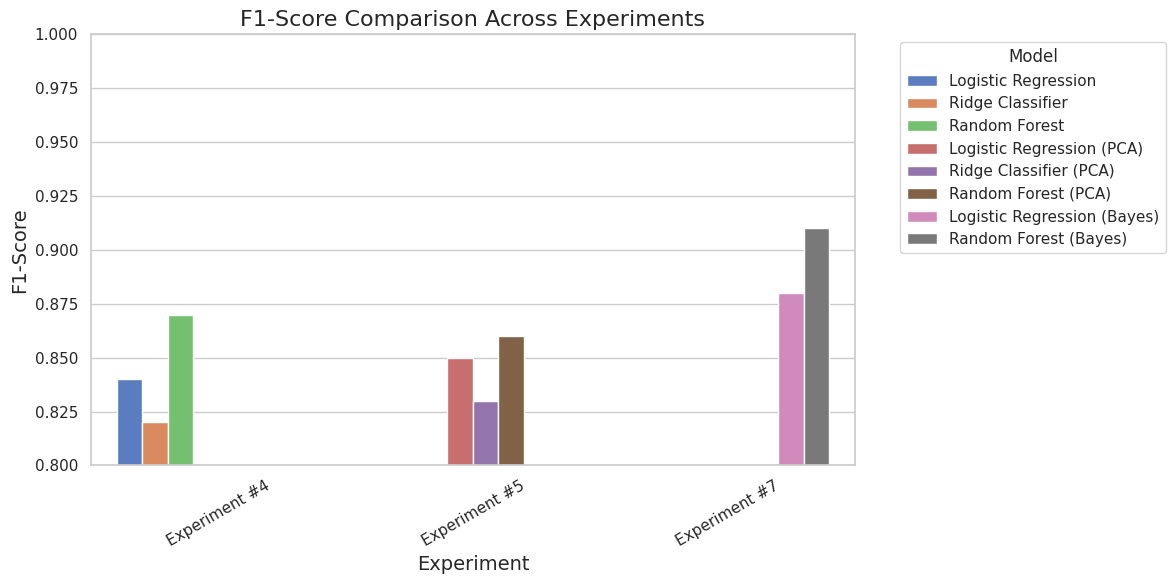

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data: Replace with actual values
data = {
    "Experiment": [
        "Experiment #4", "Experiment #4", "Experiment #4",
        "Experiment #5", "Experiment #5", "Experiment #5",
        "Experiment #7", "Experiment #7"
    ],
    "Model": [
        "Logistic Regression", "Ridge Classifier", "Random Forest",
        "Logistic Regression (PCA)", "Ridge Classifier (PCA)", "Random Forest (PCA)",
        "Logistic Regression (Bayes)", "Random Forest (Bayes)"
    ],
    "F1-Score": [0.84, 0.82, 0.87, 0.85, 0.83, 0.86, 0.88, 0.91]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Experiment", y="F1-Score", hue="Model", data=df, palette="muted"
)

# Add plot details
plt.title("F1-Score Comparison Across Experiments", fontsize=16)
plt.xlabel("Experiment", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.8, 1.0)  # Adjust as necessary based on score range
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=30)

# Show plot
plt.tight_layout()
plt.show()


In [46]:
import joblib

# Assuming `best_model` is the trained model from the final experiment
joblib.dump(best_model, "final_model.joblib")
print("Model saved as final_model.joblib")


Model saved as final_model.joblib


In [47]:
# Load the saved .joblib model
loaded_model = joblib.load("final_model.joblib")

# Example usage
prediction = loaded_model.predict(X_test)
print("Predictions:", prediction)


Predictions: [2 0 0 ... 2 2 0]


In [29]:
pip install fastapi uvicorn joblib pydantic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00


In [50]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

app = FastAPI()

class InputData(BaseModel):
    age: int
    job: str
    marital_status: str
    education: str
    balance: int
    contact: str
    day_of_week: str
    month: str
    duration: int
    campaign: int
    pdays: int
    previous: int
    poutcome: str

model = joblib.load("final_model.joblib")

@app.post("/predict")
def predict(input_data: InputData):
    # Convert input data to the format your model expects
    # This depends on how your model was trained
    data = np.array([[
        input_data.age, input_data.balance, input_data.duration,
        input_data.campaign, input_data.pdays, input_data.previous,
        # Add one-hot encoding for categorical variables
    ]])
    prediction = model.predict(data)
    return {"loan_status": "Approved" if prediction[0] == 1 else "Not Approved"}


In [49]:
df_encoded

,customer_id,age,balance,day_of_week,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,1,-0.689921,-0.217335,21,-0.941159,-0.679606,-0.646136,-0.039937,True,False,...,False,False,False,False,False,True,False,True,False,False
1,2,0.107793,-0.583372,21,1.091119,-0.679606,-0.511995,-0.473410,True,False,...,False,False,False,False,False,True,False,False,True,False
2,3,-0.689921,0.613301,21,-0.496598,-0.679606,-1.182698,0.176800,False,False,...,False,False,False,False,False,True,False,True,False,False
3,4,-0.424016,0.279685,22,-0.797206,-0.679606,-1.227412,0.176800,False,False,...,False,False,False,False,False,True,False,False,True,False
4,5,-0.424016,-0.503291,23,-0.513534,-0.679606,-0.717678,-0.039937,False,False,...,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7837,7838,-0.601286,-0.025076,16,3.830460,0.597526,2.743149,1.910693,False,True,...,False,False,False,False,True,False,False,False,True,False
7838,7839,1.082776,-0.314275,17,-0.149417,-0.679606,-0.351027,0.176800,False,False,...,False,False,False,False,True,False,False,False,False,True
7839,7840,2.855473,0.420718,17,0.163892,-0.679606,-1.638776,1.043746,False,False,...,False,False,False,False,True,False,False,True,False,False
7840,7841,2.766838,1.349591,17,3.665337,1.874657,-0.351027,-0.039937,False,False,...,False,False,False,False,True,False,False,False,False,True


In [31]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


In [38]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.139.114.64:8501

  Stopping...
  Stopping...


In [40]:
pip install pyngrok

In [41]:
from pyngrok import ngrok

# Start ngrok tunnel
public_url = ngrok.connect(port=8501)
print("Public URL:", public_url)


ERROR:pyngrok.process.ngrok:t=2024-12-21T21:56:25+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-12-21T21:56:25+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-12-21T21:56:25+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [43]:
!ngrok config add-authtoken 2qXo0kdO2xXsgtn2Sh4SZXQ8jce_459VokM1y88kqHdYuBnDE

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [44]:
from pyngrok import ngrok

# Start ngrok tunnel
public_url = ngrok.connect(port=8501)
print("Public URL:", public_url)


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [45]:
pip install -U jupyter-book

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.1/430.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installa

In [51]:
df

,Experiment,Model,F1-Score
0,Experiment #4,Logistic Regression,0.84
1,Experiment #4,Ridge Classifier,0.82
2,Experiment #4,Random Forest,0.87
3,Experiment #5,Logistic Regression (PCA),0.85
4,Experiment #5,Ridge Classifier (PCA),0.83
5,Experiment #5,Random Forest (PCA),0.86
6,Experiment #7,Logistic Regression (Bayes),0.88
7,Experiment #7,Random Forest (Bayes),0.91


In [52]:
df_result

,customer_id,age,job,marital_status,education,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,balance_duration_ratio,campaign_contact_ratio,pdays_inverse
0,1,-0.689921,admin.,married,tertiary,-0.217335,no,no,telephone,21,oct,-0.941159,-0.679606,-0.646136,-0.039937,failure,-3.693579,-0.707876,2.825945
1,2,0.107793,admin.,single,secondary,-0.583372,yes,yes,telephone,21,oct,1.091119,-0.679606,-0.511995,-0.473410,other,-0.278976,-1.290579,2.049161
2,3,-0.689921,services,married,secondary,0.613301,yes,no,telephone,21,oct,-0.496598,-0.679606,-1.182698,0.176800,failure,1.218314,-0.577503,-5.473504
3,4,-0.424016,management,married,tertiary,0.279685,yes,no,telephone,22,oct,-0.797206,-0.679606,-1.227412,0.176800,other,1.379158,-0.577503,-4.397309
4,5,-0.424016,management,married,tertiary,-0.503291,yes,no,telephone,23,oct,-0.513534,-0.679606,-0.717678,-0.039937,failure,-1.034586,-0.707876,3.542051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7837,7838,-0.601286,blue-collar,single,secondary,-0.025076,yes,no,cellular,16,nov,3.830460,0.597526,2.743149,1.910693,other,-0.005191,0.205286,0.267155
7838,7839,1.082776,management,married,tertiary,-0.314275,no,no,cellular,17,nov,-0.149417,-0.679606,-0.351027,0.176800,success,-0.369482,-0.577503,1.540896
7839,7840,2.855473,retired,married,secondary,0.420718,no,no,cellular,17,nov,0.163892,-0.679606,-1.638776,1.043746,failure,0.361475,-0.332530,-1.565493
7840,7841,2.766838,retired,married,secondary,1.349591,no,no,cellular,17,nov,3.665337,1.874657,-0.351027,-0.039937,success,0.289281,1.952639,1.540896
